In [26]:
import string
import gensim
import pymorphy2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Download processed texts

In [2]:
processed_groups_nouns = pd.read_csv('data/processed/bspb_groups_nouns.csv')

In [3]:
processed_groups_nouns['clear_texts'] = processed_groups_nouns['nouns_name'] + ' ' + processed_groups_nouns['nouns_description']

In [4]:
processed_groups_nouns = processed_groups_nouns.loc[processed_groups_nouns['clear_texts'].notna()]

In [5]:
combined_df = processed_groups_nouns['clear_texts']

In [21]:
processed_groups_nouns

,Unnamed: 0,id,name,status,description,activity,members_count,clear_name,clear_description,nouns_name,nouns_description,clear_texts
0,0,1,ВКонтакте API,Платформа для разработчиков приложений,Группа посвящена разработке приложений на осно...,Open group,383414.0,вконтакте api,группа посвящать разработка приложение основа ...,вконтакте,группа разработка приложение основа платформа ...,вконтакте группа разработка приложение основа ...
1,1,113246211,"Сайт, видеомонтаж, портфолио для учителей, восп.","Заказ ПОРТФОЛИО, видеопоздравлений, видеопрезе...","Выполняю работы по созданию сайтов, портфолио,...",Other services,225.0,сайт видеомонтаж портфолио учитель воспа,выполнять работа создание сайт портфолио видео...,сайт видеомонтаж портфолио учитель воспа,работа создание сайт портфолио видеоролик виде...,сайт видеомонтаж портфолио учитель воспа работ...
2,2,180355074,Орешкин лес.Украшения из дерева от Александрины.,Привет.\tМеня зовут Александрина .Я создаю укр...,"Жители этого леса - украшения ,они рассказываю...",Artist,1929.0,орешкин лес украшение дерево александрина,житель лес украшение рассказывать история леге...,орешкин лес украшение дерево александрина,житель лес украшение история легенда любовь те...,орешкин лес украшение дерево александрина жите...
9,9,192937987,Гринвэй Кронштадт,NaN,☘️ GreenWay - это уникальные и доступные ЭКО -...,Household Products,105.0,гринвэй кронштадт,__u2618__ greenway это уникальный доступный эк...,гринвэй кронштадт,эко продукт жизнь помощь нанотехнология чистот...,гринвэй кронштадт эко продукт жизнь помощь нан...
11,11,14,Дом Культуры,Дом культуры,Анонсы культурных событий Петербурга (и немнож...,Community Center,5991.0,дом культура,анонс культурный событие петербург немножко мо...,дом культура,анонс событие петербург москва,дом культура анонс событие петербург москва
...,...,...,...,...,...,...,...,...,...,...,...,...
912471,912471,64449308,Музейный центр Ваприикки | Тампере | Финляндия,Музей | Сайт музея на русском языке: www.vapri...,Музейный центр Ваприикки в центре города Тампе...,"Museum, gallery, exhibition",183.0,музейный центр ваприикки тампере финляндия,музейный центр ваприикки центр город тампере п...,центр ваприикки тампере финляндия,центр ваприикки центр город тампере семья биле...,центр ваприикки тампере финляндия центр ваприи...
912476,912476,104857566,"ПРОДАЖА,ПОКУПКА и ОБМЕН АВТОМОБИЛЕЙ .(AUTOHOUSE)",Тел. 8-953-231-48-00,"- Оформление, договора купли-продажи в любое в...",Transport,135.0,продажа покупка обмен автомобиль autohouse,оформление договор купля продажа любой время п...,продажа покупка обмен автомобиль,оформление договор купля продажа время продажа...,продажа покупка обмен автомобиль оформление до...
912480,912480,83908177,Продукты с фермы,Фермерские продукты,Натуральные продукты с фермы\n\nМы обеспечивае...,Internet store,847.0,продукт ферма,натуральный продукт ферма обеспечивать свой кл...,продукт ферма,продукт ферма клиент продукция сыр сулугуни сы...,продукт ферма продукт ферма клиент продукция с...
912485,912485,54525929,Байконур | Новости | Объявления - 94info,Все объявления Байконура в одном месте!,Для размещения объявления в группе нажимаем ''...,City community,47036.0,байконур новость объявление,размещение объявление группа нажимать __u0001f...,байконур новость объявление,размещение объявление группа запись правило ре...,байконур новость объявление размещение объявле...


## LDA model

### Train model on full corpus of texts: posts, reposts, groups

In [6]:
texts_list = [str(values).split() for values in combined_df]

In [7]:
id2word = corpora.Dictionary(texts_list)

In [8]:
corpus = []
for text in texts_list:
    corpus.append(id2word.doc2bow(text))

### Topics number search

In [10]:
perplexity_nouns_metrics = []
coherence_nouns_metrics = []

for topic_n in range(4,15):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=topic_n, 
                                            random_state=42,
                                            update_every=1,
                                            chunksize=5000,
                                            passes=10,
                                            iterations=10,
                                            alpha='auto',
                                            per_word_topics=True)
    
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_nouns_metrics.append(perplexity)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts_list, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_nouns_metrics.append(coherence_lda)
    
    lda_model.save(f'lda_model_groups_notna_{topic_n}.model')
    print(topic_n)

4
5
6
7
8
9
10
11
12
13
14


### Model choosing and evaluation

#### Coherence

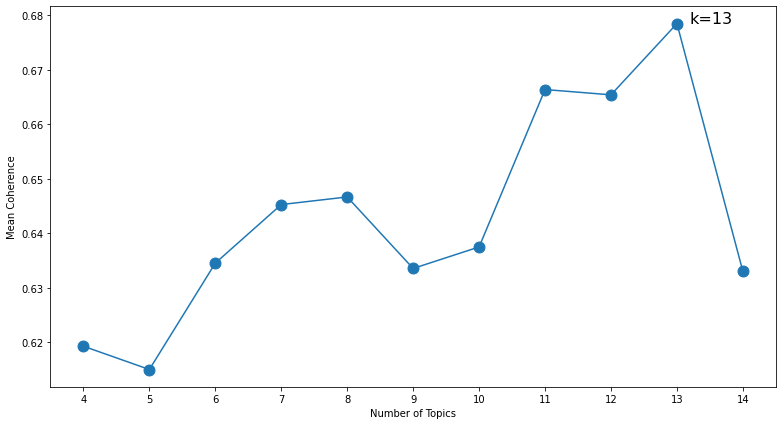

In [11]:
fig = plt.figure(figsize=(13,7))

ax = plt.plot(list(range(4,15)), coherence_nouns_metrics)

plt.xticks(list(range(4,15)))
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

plt.scatter(list(range(4,15)), coherence_nouns_metrics, s=120)

ymax = max(coherence_nouns_metrics)
xpos = coherence_nouns_metrics.index(ymax)
best_k = list(range(4,15))[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

plt.show()

#### Perplexity

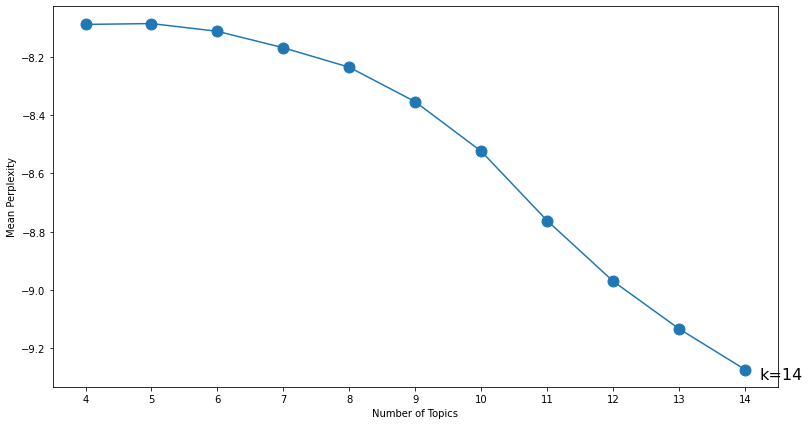

In [12]:
fig = plt.figure(figsize=(13,7))

ax = plt.plot(list(range(4,15)), perplexity_nouns_metrics)

plt.xticks(list(range(4,15)))
plt.xlabel("Number of Topics")
plt.ylabel("Mean Perplexity")

plt.scatter(list(range(4,15)), perplexity_nouns_metrics, s=120)

ymax = min(perplexity_nouns_metrics)
xpos = perplexity_nouns_metrics.index(ymax)
best_k = list(range(4,15))[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

plt.show()

## The best number of topics = 13

## Visualization

In [13]:
lda_model_13_topics = gensim.models.ldamodel.LdaModel.load('lda_model_groups_notna_13.model')

In [14]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_13_topics, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.387016 -0.138278       1        1  14.362875
4      0.027283  0.021809       2        1  10.359059
8     -0.232878 -0.315721       3        1  10.302154
11    -0.070034  0.381333       4        1   9.189388
12     0.051766 -0.174231       5        1   9.168886
9      0.237845 -0.364839       6        1   7.816618
10     0.052422  0.242031       7        1   6.826323
0     -0.018940 -0.398056       8        1   6.163549
6     -0.348728  0.076959       9        1   6.146825
7      0.246024  0.377948      10        1   5.488822
3      0.393794  0.140139      11        1   5.449224
1     -0.266519  0.294949      12        1   4.912332
5     -0.459050 -0.144044      13        1   3.813945, topic_info=            Term           Freq          Total Category  logprob  loglift
2         группа  146858.000000  146858.000000  Default  30.0000  30.0000
241      человек   72355.000000   72355.000000  Default  29.0000  29.0000
387   объявление   43577.000000   43577.000000  Default  28.0000  28.0000
271      новость   59375.000000   59375.000000  Default  27.0000  27.0000
77     петербург   32869.000000   32869.000000  Default  26.0000  26.0000
...          ...            ...            ...      ...      ...      ...
2338    беларусь    1933.720817    3506.669058  Topic13  -5.3136   2.6713
53        россия    3502.676366   44336.967331  Topic13  -4.7196   0.7282
161          мир    2719.701717   43411.364866  Topic13  -4.9726   0.4963
282        место    2262.599798   31800.728471  Topic13  -5.1566   0.6235
46        москва    2061.804404   27610.674489  Topic13  -5.2495   0.6719

[785 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2029      7  0.009116          авто
2029     10  0.990776          авто
7262     10  0.999521  автозапчасть
8591      2  0.999317      автозвук
130       7  0.193875    автомобиль
...     ...       ...           ...
954       5  0.799508          язык
954       6  0.200447          язык
2678      2  0.890170        яндекс
2678      4  0.094153        яндекс
2678     10  0.015217        яндекс

[1518 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 9, 12, 13, 10, 11, 1, 7, 8, 4, 2, 6])

In [16]:
vis.token_table

,Topic,Freq,Term
term,,,
2029,7,0.009116,авто
2029,10,0.990776,авто
7262,10,0.999521,автозапчасть
8591,2,0.999317,автозвук
130,7,0.193875,автомобиль
...,...,...,...
954,5,0.799508,язык
954,6,0.200447,язык
2678,2,0.890170,яндекс
